<a name='T'></a>

# <p style="background-image: linear-gradient(to right, rgba(50, 49, 90, 0.9), rgba(49, 49, 49, 0.0)), url(https://www.thedataschool.com.au/wp-content/uploads/2020/09/stock-tracking-screen-wo.jpg); background-size: cover; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; font-size: 250%; color: #E82127; text-align: center; border-radius: 5px 5px;; padding: 20px; box-shadow: 5px 5px 30px #333"> Tesla Stock Forecasting   <br> Using LSTM
</p>
    <img src="https://images.pixexid.com/unleash-the-power-of-technology-with-a-2023-tesla-model-s-plaid-speeding-throug-bxx0b5la.jpeg" style="width: 40%; margin: 0 auto; display: block; border-radius: 100px 10px; box-shadow: 5px 5px 30px #333;">
</div>

## &#8711; <span style='color:red'>|</span> Table of Contents
1. [`Introduction`](#I)
2. [`Tesla Data`](#D)
3. [`Imports & Setup`](#is)
    * 3.1 [`Tesla Data`](#tsladata)
4. [`Data Visualization`](#DV)
    * 4.1 [`Candlestick Plots`](#DV)
    * 4.2 [`Stock Splits`](#splits)
    * 4.3 [`Percentage Change in Stock`](#pchange)
5. [`Single Step LSTM`](#lstm)
    * 5.1 [`Data Prep`](#lstm)
    * 5.2 [`Model Building`](#buildmodel)
    * 5.3 [`Predictions`](#pred)
6. [`Multi-Step Stacked LSTM`](#mlstm)
    * 6.1 [`Multi-Step Math Background`](#mlstm)
    * 6.2 [`Stacked LSTM Background`](#background)
    * 6.3 [`Multi-Step Data Prep`](#mutlidataprep)
    * 6.4 [`Buidling Stacked LSTM`](#buildmlstm)
    * 6.5 [`Forecasting Multi-Step Stacked LSTM`](#forecast)
7. [`Bottom`](#B)

Author: [Math & Physics Fun with Gus](https://mathphysicsfunwithgus.square.site)

<a name='I'>

# <p style="background-image: linear-gradient(to right, rgba(49, 49, 90, 0.9), rgba(49, 49, 49, 0.0)), url(https://www.thedataschool.com.au/wp-content/uploads/2020/09/stock-tracking-screen-wo.jpg); background-size: cover; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; font-size: 125%; color: #E82127; text-align: left; border-radius: 5px; padding: 10px; box-shadow: 2px 2px 5px #333; margin-bottom: -10px;"> 1 $\vert$ Introduction </p>
    
In this notebook, we will explore the application of Long Short-Term Memory (LSTM) networks, a special kind of Recurrent Neural Network (RNN), for forecasting Tesla's stock prices.

LSTMs, or Long Short-Term Memory networks, are specifically crafted to identify intricate patterns within sequential data. This makes them particularly effective for tasks involving time series data, like predicting stock prices, or processing linguistic sequences, such as phrases and sentences. Unlike standard feedforward neural networks, LSTMs have feedback connections that allow them to process not just single data points, but entire sequences of data. For a stock price prediction model, this allows the LSTM to consider the historical sequence of stock prices in making predictions about future prices.

### <p style="background-image: linear-gradient(to right, rgba(49, 49, 90, 0.9), rgba(49, 49, 49, 0.0)), url(https://www.thedataschool.com.au/wp-content/uploads/2020/09/stock-tracking-screen-wo.jpg); background-size: cover; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; font-size: 105%; color: #E82127; text-align: left; border-radius: 5px; padding: 10px; box-shadow: 2px 2px 5px #333; margin-bottom: -10px;"> 1.1.1 $\vert$ LSTM Intuitive Explanation </p>

An LSTM unit is designed to keep track of dependencies in input sequences. It does this through structures called gates which regulate the flow of information. These gates decide what to retain in memory (cell state) and what to forget based on the current input and previous state.

- **Forget Gate $f_t$**: This gate decides which information from the cell state should be thrown away or kept. It looks at the previous output $h_{t-1}$ and the current input $x_t$ and applies a sigmoid function to output numbers between 0 and 1 for each number in the cell state $C_{t-1}$. A 1 represents “completely keep this” while a 0 represents “completely get rid of this.”

- **Input Gate $i_t$**: This gate updates the cell state with new information. It first decides which values to update using a sigmoid function, and then creates a new vector of candidate values, $\nu(C_t)$, that could be added to the state.

- **Cell State $C_t$**: This is the memory of the LSTM. It is updated by forgetting the things deemed unnecessary and adding new candidate values scaled by their importance.

- **Output Gate $o_t$**: Finally, the output is computed. The cell state is passed through `tanh` (to push the values to be between -1 and 1) and then multiplied by the output of the sigmoid gate, so that we only output the parts we decided to [1, 2].

<center>
<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png"  width="60%" height="30%">
</center>



### <p style="background-image: linear-gradient(to right, rgba(49, 49, 90, 0.9), rgba(49, 49, 49, 0.0)), url(https://www.thedataschool.com.au/wp-content/uploads/2020/09/stock-tracking-screen-wo.jpg); background-size: cover; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; font-size: 105%; color: #E82127; text-align: left; border-radius: 5px; padding: 10px; box-shadow: 2px 2px 5px #333; margin-bottom: -10px;"> 1.1.2 $\vert$ LSTM Mathematical Explanation </p>

The LSTM cell computes the following functions at each step `t` of the sequence:

- **Forget Gate $f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$**: This gate decides which information is irrelevant from the cell state by looking at the previous output and the current input.

- **Input Gate $i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$**: It decides which values will be updated in the cell state. 

- **Cell Input $\tilde{C_t} = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$**: It creates a vector of new candidate values that could be added to the cell state.

- **Cell State Update $C_t = f_t * C_{t-1} + i_t * \tilde{C}_t$**: The cell state is updated by forgetting things (multiplying by $f_t$) and adding new candidate values (multiplying by $i_t$).

- **Output Gate $o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$**: It decides what the next hidden state ($h_t$) should be.

- **Hidden State Output $h_t = o_t * \tanh(C_t)$**: The output is based on the cell state but only certain parts are allowed to be outputted (controlled by $o_t$). 

Each of these steps involves a combination of weights ($W$), biases ($b$), and the previous hidden state and current input, which are trained during the learning process. The LSTM's ability to maintain a long-term memory is largely due to the cell state $C_t$ and how the gates interact to modify this memory.

We will start by examining the Tesla stock data set, which includes daily trading information such as open, high, low, close prices, and trading volume[1, 2].

<a name='D'>

# <p style="background-image: linear-gradient(to right, rgba(49, 49, 90, 0.9), rgba(49, 49, 49, 0.0)), url(https://www.thedataschool.com.au/wp-content/uploads/2020/09/stock-tracking-screen-wo.jpg); background-size: cover; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; font-size: 125%; color: #E82127; text-align: left; border-radius: 5px; padding: 10px; box-shadow: 2px 2px 5px #333; margin-bottom: -10px;"> 2 $\vert$ Tesla Stock Dataset Overview </p>
    
In this analysis, we will be delving into the stock data for Tesla, Inc. (TSLA). Tesla is renowned for its innovative approach to electric vehicles, energy storage, and solar panel manufacturing. As a company at the forefront of the transition to sustainable energy, Tesla's stock market performance is of significant interest to investors, market analysts, and enthusiasts of technology and sustainability. The dataset comprises daily trading information captured in several key financial metrics:

- `open`: The price at which the stock started trading when the market opened on a given day.
- `high`: The highest price at which the stock traded during the day.
- `low`: The lowest price at which the stock traded during the day.
- `close`: The last price at which the stock traded during the day. This is the figure most commonly reported in the financial news.
- `volume`: The number of shares or contracts traded in a security or an entire market during a given period. It is a measure of the total demand for and supply of the stock.
- `dividends`: The distribution of reward from a portion of the company's earnings and is paid to a class of its shareholders.
- `stock splits`: An action taken by a company to divide its existing shares into multiple shares to boost the liquidity of the shares. Although the number of shares outstanding increases by a specific multiple, the total dollar value of the shares remains the same compared to pre-split amounts, because the split does not add any real value.

The historical stock data for Tesla provides insights into the company's stock performance over time. By analyzing patterns in this data, we can attempt to forecast future stock prices using machine learning techniques such as Long Short-Term Memory (LSTM) networks.

<a name='is'>

# <p style="background-image: linear-gradient(to right, rgba(49, 49, 90, 0.9), rgba(49, 49, 49, 0.0)), url(https://www.thedataschool.com.au/wp-content/uploads/2020/09/stock-tracking-screen-wo.jpg); background-size: cover; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; font-size: 125%; color: #E82127; text-align: left; border-radius: 5px; padding: 10px; box-shadow: 2px 2px 5px #333; margin-bottom: -10px;"> 3 $\vert$ Imports & Setup </p>

In [26]:
# Data Imports
import yfinance as yf
import pandas as pd 
import numpy as np 
import random

from sklearn.preprocessing import MinMaxScaler
from pandas.tseries.offsets import BDay

# Visualization Imports
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import scipy.stats as stats

# Neural Network Imports
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint

# Setting seed
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Visualization Configurations
pio.templates.default = "plotly_dark"
%config InlineBackend.figure_format = 'retina'

<a name='tsladata'>
    
## <p style="background-image: linear-gradient(to right, rgba(49, 49, 90, 0.9), rgba(49, 49, 49, 0.0)), url(https://www.thedataschool.com.au/wp-content/uploads/2020/09/stock-tracking-screen-wo.jpg); background-size: cover; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; font-size: 115%; color: #E82127; text-align: left; border-radius: 5px; padding: 10px; box-shadow: 2px 2px 5px #333; margin-bottom: -10px;"> 3.1 $\vert$ Tesla Data </p>

In [28]:
def show(data: pd.DataFrame):
    df = data.copy()
    df = df.style.format(precision=3)
    df = df.background_gradient(cmap='Reds', axis=0)
    display(df)

def highlight_half(data: pd.DataFrame, axis=1, precision=3):
    
    s = data.shape[1] if axis else data.shape[0]
    data_style = data.style.format(precision=precision)

    def apply_style(val):
        style1 = 'background-color: red; color: white'
        style2 = 'background-color: blue; color: white'
        return [style1 if x < s//2 else style2 for x in range(s)]

    display(data_style.apply(apply_style, axis=axis))

In [29]:
# Target stock & columns for modeling
SYMBOL = "TSLA"
columns = ['open', 'high', 'low', 'close', 'volume']

# Getting Tesla (TSLA) stock data
ticker = yf.Ticker(SYMBOL)

# End stock dates
end_date = "2023-12-01"

# Pulling stock data 
df = ticker.history(start="2017-01-01", end=end_date)
df.columns = df.columns.str.lower()

# Showing data
show(df.tail())

In [30]:
# Data info
print('Data Info:')
df.info()

Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1740 entries, 2017-01-03 00:00:00-05:00 to 2023-11-30 00:00:00-05:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   open          1740 non-null   float64
 1   high          1740 non-null   float64
 2   low           1740 non-null   float64
 3   close         1740 non-null   float64
 4   volume        1740 non-null   int64  
 5   dividends     1740 non-null   float64
 6   stock splits  1740 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 108.8 KB


<a name='DV'>

# <p style="background-image: linear-gradient(to right, rgba(49, 49, 90, 0.9), rgba(49, 49, 49, 0.0)), url(https://www.thedataschool.com.au/wp-content/uploads/2020/09/stock-tracking-screen-wo.jpg); background-size: cover; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; font-size: 125%; color: #E82127; text-align: left; border-radius: 5px; padding: 10px; box-shadow: 2px 2px 5px #333; margin-bottom: -10px;"> 4 $\vert$ Data Visualization <br> <small style="font-size: 80%;">  4.1 $\vert$ Candle Stick Plots <br> </p>

Candlestick charts are a visual tool for market analysis, used to describe price movements of a security, derivative, or currency. Each "candlestick" typically represents one day of trading and is composed of a body and wicks.
- **Body**: The wider section of the candlestick which indicates the opening and closing prices. If the body is filled or dark, the security closed lower than it opened. If the body is empty or light, it closed higher than it opened.
- **Wicks**: Lines that extend from the top and bottom of the body representing the high and low prices during the period.


In [32]:
def plot_candlestick(stock_df, name='', rolling_avg=None, fig_size=(1300, 700)):
    """
    Plot a candlestick chart for the given stock dataframe with optional rolling averages.
    
    Args:
        stock_df (pd.DataFrame): The stock data as a pandas DataFrame.
        name (str): The name of the stock, defaults to 'Tesla'.
        rolling_avg (list of int, optional): A list of integers for rolling average window sizes.
        fig_size (tuple): The figure size, defaults to (1300, 700).
    """
    # Copy df to avoid modifying the original data
    stock_data = stock_df.copy()
    
    # Creating plot
    fig = go.Figure(data=[go.Candlestick(x=stock_data.index,
        close=stock_data['close'], open=stock_data['open'], high=stock_data['high'], low=stock_data['low'], 
        name="Candlesticks", increasing_line_color='green', decreasing_line_color='red', line=dict(width=1)
                                        )])
    # Rolling averages if specified
    if rolling_avg:
        colors = ['rgba(0, 255, 255, 0.5)',   # cyan
                  'rgba(255, 255, 0, 0.5)',   # yellow
                  'rgba(255, 165, 0, 0.5)',   # orange
                  'rgba(255, 105, 180, 0.5)', # pink
                  'rgba(165, 42, 42, 0.5)',   # brown
                  'rgba(128, 128, 128, 0.5)', # gray
                  'rgba(128, 128, 0, 0.5)',   # olive
                  'rgba(0, 0, 255, 0.5)']     # blue
        
        for i, avg in enumerate(rolling_avg):
            color = colors[i % len(colors)]
            ma_column = f'{avg}-day MA'
            stock_data[ma_column] = stock_data['close'].rolling(window=avg).mean()

            # Moving average trace
            fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data[ma_column],
                    mode='lines', name=f'{avg}-day Moving Average', line=dict(color=color)))

    # Layout updates
    fig.update_layout(title=f"{name} Stock Price - Candlestick Chart",
                      xaxis_title="Date", yaxis_title="Price",
                      width=fig_size[0], height=fig_size[1],
                      xaxis=dict(
                          rangeselector=dict(
                              buttons=list([
                                  dict(count=14, label="2w", step="day", stepmode="backward"),
                                  dict(count=1, label="1m", step="month", stepmode="backward"),
                                  dict(count=3, label="3m", step="month", stepmode="backward"),
                                  dict(count=6, label="6m", step="month", stepmode="backward"),
                                  dict(count=1, label="YTD", step="year", stepmode="todate"),
                                  dict(count=1, label="1y", step="year", stepmode="backward"),
                                  dict(count=2, label="2y", step="year", stepmode="backward"),
                                  dict(count=3, label="3y", step="year", stepmode="backward"),
                                  dict(count=5, label="5y", step="year", stepmode="backward"),
                                  dict(step="all")]),
                              bgcolor='pink',
                              font=dict(color='black'),
                              activecolor='lightgreen'))
                     )
    fig.show()


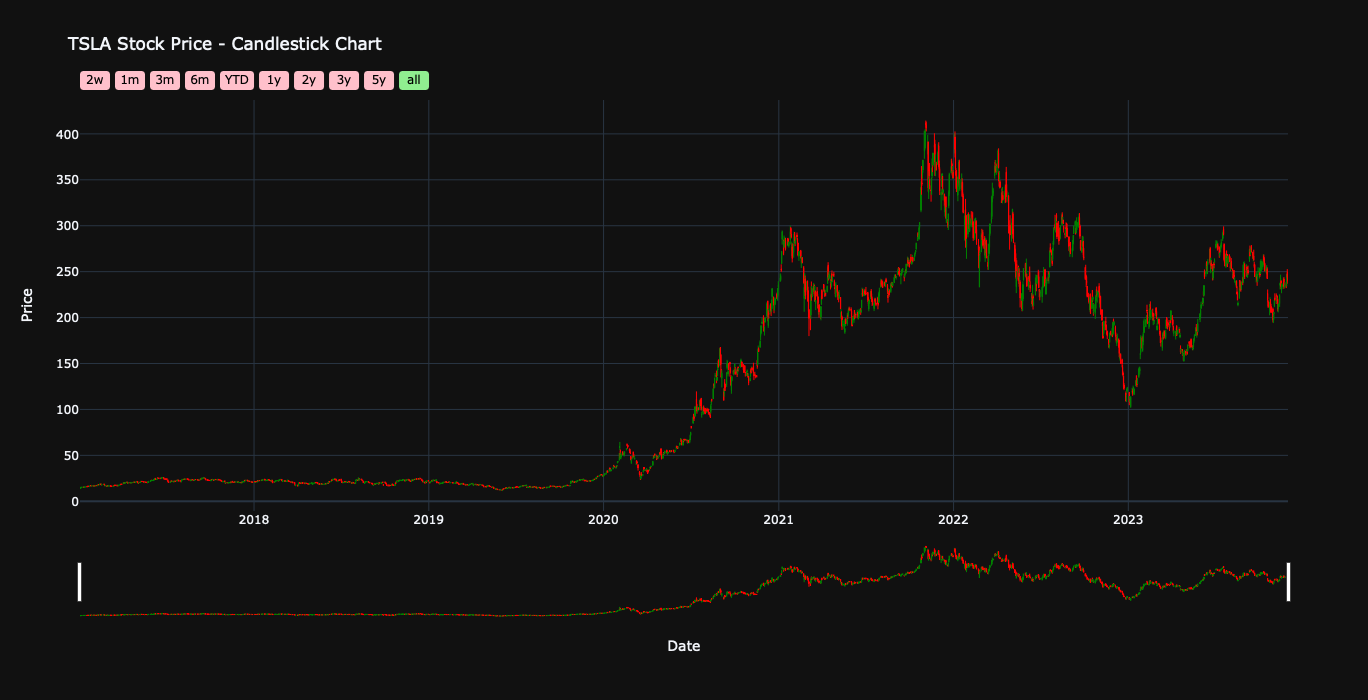

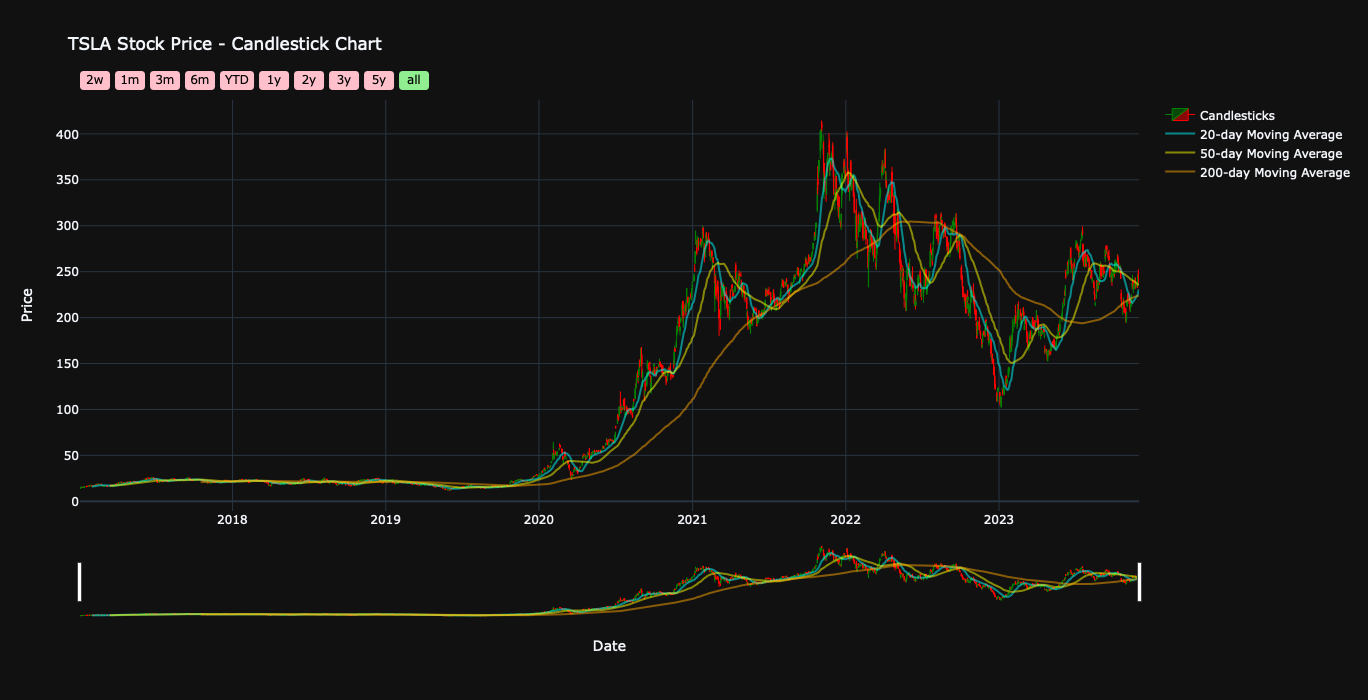

In [33]:
# General Tesla stocks
plot_candlestick(df, name=SYMBOL)

# With Moving averages
plot_candlestick(df, name=SYMBOL, rolling_avg=[20, 50, 200])

<a name='splits'>
    
## <p style="background-image: linear-gradient(to right, rgba(49, 49, 90, 0.9), rgba(49, 49, 49, 0.0)), url(https://www.thedataschool.com.au/wp-content/uploads/2020/09/stock-tracking-screen-wo.jpg); background-size: cover; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; font-size: 115%; color: #E82127; text-align: left; border-radius: 5px; padding: 10px; box-shadow: 2px 2px 5px #333; margin-bottom: -10px;"> 4.2 $\vert$ Tesla Stock Splits </p>

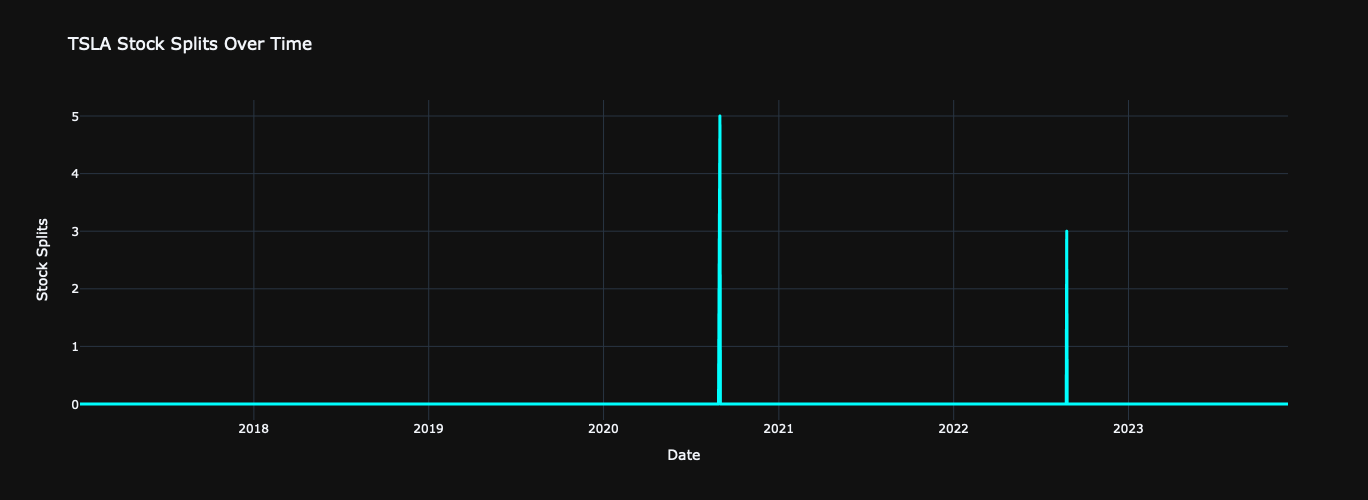

In [35]:
# Plotting stock splits
fig = px.line(x=df.index, y=df['stock splits'], title=f'{SYMBOL} Stock Splits Over Time')
fig.update_layout(width=1300, height=500)
fig.update_traces(line=dict(color='cyan', width=3))
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Stock Splits')
fig.show()

<a name='pchange'>
    
## <p style="background-image: linear-gradient(to right, rgba(49, 49, 90, 0.9), rgba(49, 49, 49, 0.0)), url(https://www.thedataschool.com.au/wp-content/uploads/2020/09/stock-tracking-screen-wo.jpg); background-size: cover; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; font-size: 115%; color: #E82127; text-align: left; border-radius: 5px; padding: 10px; box-shadow: 2px 2px 5px #333; margin-bottom: -10px;"> 4.3 $\vert$ Percentage Change in Stock Prices </p>
    
The percentage change in stock prices is a measure used to express the change in price over time as a proportion of the previous price. This metric is useful for comparing the performance of a stock across different time frames or against other stocks. The formula to calculate the daily percentage change is:
$$\text{Percentage Change} = \left( \frac{\text{Current Price} - \text{Previous Price}}{\text{Previous Price}} \right) \times 100
$$
- **Current Price** is the price of the stock at the end of the current period (e.g., end of the day).
- **Previous Price** is the price of the stock at the end of the previous period.

For the first period in a time series data set (e.g., the first day of available stock data), the percentage change is not defined as there is no previous price to compare to. In such cases, it is common to set the percentage change to zero or to omit the value. When analyzing stock data over a longer period, such as a month or year, the percentage change is calculated using the price at the beginning and the end of the period. This metric is commonly used in financial analysis to assess the volatility and performance of stocks. It is also a key indicator for investors making decisions about buying or selling securities.


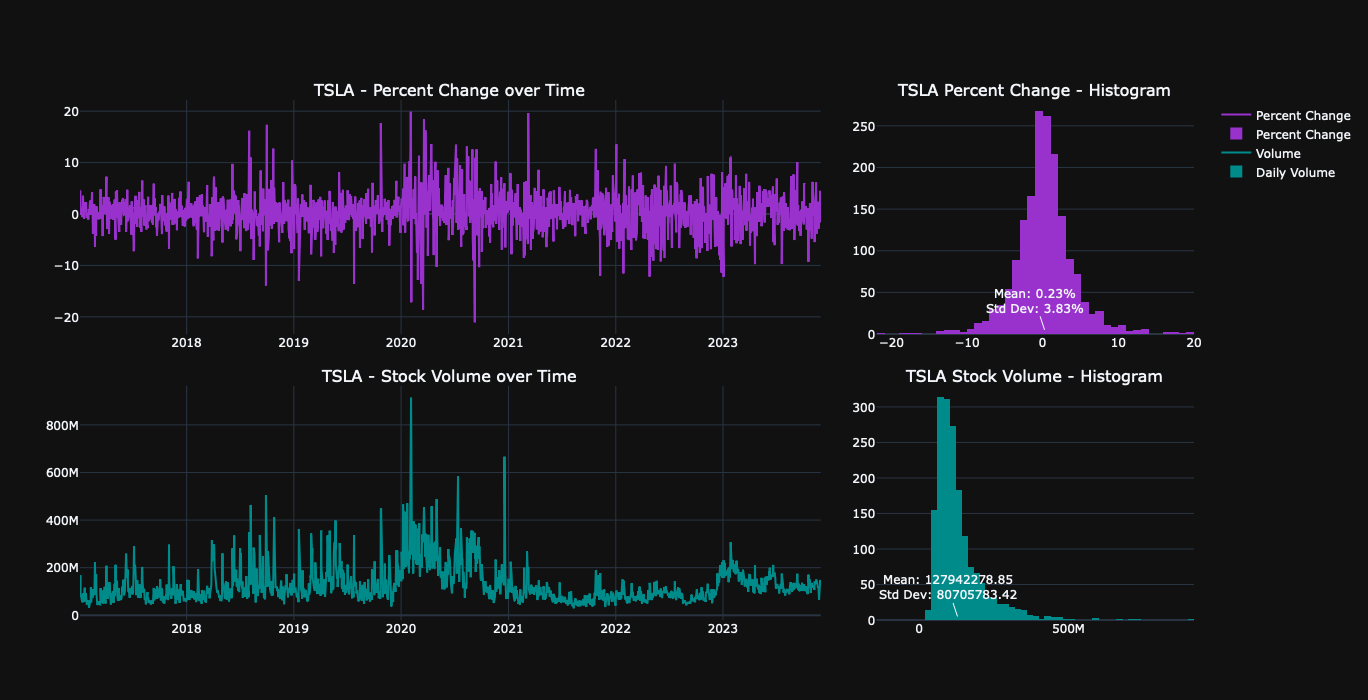

In [37]:
# Creating subplot
fig = make_subplots(rows=2, cols=2, column_widths=[0.7, 0.3],
                    vertical_spacing=0.1, horizontal_spacing=0.05,
                    subplot_titles=(f"{SYMBOL} - Percent Change over Time", f"{SYMBOL} Percent Change - Histogram",
                                    f"{SYMBOL} - Stock Volume over Time", f"{SYMBOL} Stock Volume - Histogram",))
# Percent Change Plot
percent_change = df['close'].pct_change() * 100
fig.add_trace(go.Scatter(x=df.index, y=percent_change, name='Percent Change', marker_color='darkorchid'), row=1, col=1)
fig.add_trace(go.Histogram(x=percent_change, nbinsx=50, name='Percent Change', marker_color='darkorchid'),  row=1, col=2)
fig.add_annotation(text=f"Mean: {percent_change.mean():.2f}%<br>Std Dev: {percent_change.std():.2f}%",
                   xref='x2', yref='y2', x=percent_change.mean(), y=5, showarrow=True)
# Volume Plot
fig.add_trace(go.Scatter(x=df.index, y=df['volume'], name='Volume', marker_color='darkcyan'), row=2, col=1)
fig.add_trace(go.Histogram(x=df['volume'], nbinsx=50, name='Daily Volume', marker_color='darkcyan'),  row=2, col=2)
fig.add_annotation(text=f"Mean: {df['volume'].mean():.2f}<br>Std Dev: {df['volume'].std():.2f}",
                   xref='x4', yref='y4', x=df['volume'].mean(), y=5, showarrow=True)

fig.update_layout(height=700, width=1300)
fig.show()

- **Tesla Percent Change over Time:** plot displays the daily percentage change of Tesla's stock price, revealing the volatility over the observed period. The fluctuations are captured by sharp spikes and dips, indicating days with significant price movements. This could be reflective of market reactions to news events, earnings reports, or broader economic conditions.

- **Tesla Percent Change - Histogram:** plot on the top right presents the distribution of these daily percentage changes. Most changes cluster around the mean, suggesting a normal distribution of returns, which is typical for stock prices over time. The mean close to zero implies stable average growth, while the standard deviation indicates the extent of variation from the average.

- **Tesla Stock Volume over Time:** showing the traded volume of Tesla's stock. Peaks in this plot could correspond to specific events or the release of significant news affecting investor sentiment and trading behavior.

- **Tesla Stock Volume - Histogram:** illustrates the distribution of trading volume, indicating how often certain volumes occur. The mean and standard deviation provide a summary of the typical volume and its variability. The concentration of data on the lower end suggests that high-volume days are less frequent but can be associated with key market or company-specific events.

<a name='lstm'>

    
# <p style="background-image: linear-gradient(to right, rgba(49, 49, 90, 0.9), rgba(49, 49, 49, 0.0)), url(https://www.thedataschool.com.au/wp-content/uploads/2020/09/stock-tracking-screen-wo.jpg); background-size: cover; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; font-size: 150%; color: #E82127; text-align: left; border-radius: 5px; padding: 10px; box-shadow: 2px 2px 5px #333; margin-bottom: -10px;"> 5 $\vert$ LSTM <br> <small style="font-size: 80%;">  5.1 $\vert$ LSTM Data Prep <br> </p>

In machine learning, it's often crucial, especialy when using neural networks, to normalize data before feeding it into a model. This process adjusts values measured on different scales to a notionally common scale, often prior to averaging. Here, we use the `MinMaxScaler` from the `sklearn.preprocessing` package, which scales each feature by its maximum and minimum values. This scaler transforms each value `v` in a feature column to `v'` in the range [0, 1] using the following formula:
$$v' = \frac{v - \text{min}(v)}{\text{max}(v) - \text{min}(v)}$$
- `v` is the original value.
- `min(v)` is the minimum value in the feature column.
- `max(v)` is the maximum value in the feature column.
The columns `['open', 'high', 'low', 'close', 'volume']` from the Tesla stock dataset are normalized, which includes the opening, high, low, and closing prices along with the trading volume. Normalizing these features allows for a more stable and faster convergence during the training of neural networks, like the LSTM model we'll be using for stock price forecasting.


In [40]:
class RNNFormater:
    
    def __init__(self, data: pd.DataFrame, mapping_steps=10):
        """
        Initialize the RNNFormater with a DataFrame and steps to map for data.
        
        Args:
            data (pd.DataFrame): Input DataFrame containing time series data.
            mapping_steps (int): Number of time steps for each input sequence to be mapped to output.
        """
        # Storing data
        self.df = data.copy()
        self.data = self.df.values

        # Scaler stored for usage later
        self.scaler = MinMaxScaler()
        self.normalized_data = self.scaler.fit_transform(self.data)
        
        self.time_steps = data.shape[0]
        self.n_columns = data.shape[1]

        # Number of mapping steps
        self.mapping_steps = mapping_steps

    def data_mapping(self):
        """
        Maps a 2D array into a 3D array for RNNs input, with each sequence having mapping_steps time steps.
    
        Args:
            mapping_steps (int): Number of time steps for each sequence.
    
        Returns:
            np.array: A 3D array suitable for RNN inputs.
        """
        mapping_steps = self.mapping_steps + 1
        
        mapping_iterations = self.time_steps - mapping_steps + 1
        self.normalized_data_mapped = np.empty((mapping_iterations, mapping_steps, self.n_columns))
        
        for i in range(mapping_iterations):
            self.normalized_data_mapped[i, :, :] = self.normalized_data[i:i + mapping_steps, :]
        
        return self.normalized_data_mapped
    
    def rnn_train_test_split(self, test_percent=0.1):
        """
        Splits the 3D mapped data into training and testing sets for an RNN.
        
        Args:
            test_percent (float): The fraction of data to be used for testing.
        
        Returns:
            tuple: X_train, X_test, y_train, y_test
        """
        self.test_size = int(np.round(self.normalized_data_mapped.shape[0] * test_percent))
        self.train_size = self.normalized_data_mapped.shape[0] - self.test_size
        
        X_train = self.normalized_data_mapped[:self.train_size, :-1, :]
        y_train = self.normalized_data_mapped[:self.train_size, -1, :]
        
        X_test = self.normalized_data_mapped[self.train_size:, :-1, :]
        y_test = self.normalized_data_mapped[self.train_size:, -1, :]
        
        return X_train, X_test, y_train, y_test  

    def forecast_n_steps(self, model, data: pd.DataFrame, n_forecast_steps=30):
        """
        Forecast multiple steps ahead using the LSTM model.
    
        Args:
            model (tf.keras.Model): Trained LSTM model for prediction.
            data (pd.DataFrame): Input DataFrame containing the latest time series data.
            n_forecast_steps (int): Number of future steps to forecast.
    
        Returns:
            np.array: Forecasted values for n_forecast_steps.
        """
        # Scaling the latest 'mapping_steps' data for mapping
        last_steps = self.scaler.transform(data.values)[-self.mapping_steps:]
    
        # Initialize normalized_data_mapped array
        normalized_data_mapped = np.empty((n_forecast_steps, self.mapping_steps, self.n_columns))
    
        # Initialize predictions array
        predictions = np.empty((n_forecast_steps, self.n_columns))
    
        # Predict the first step
        normalized_data_mapped[0, :, :] = last_steps
        predictions[0, :] = model.predict(normalized_data_mapped[0, :, :].reshape(1, self.mapping_steps, self.n_columns), verbose=False)
    
        # Generate predictions and update normalized_data_mapped for each subsequent step
        for i in range(1, n_forecast_steps):
            # Shift the window and insert new prediction at end
            normalized_data_mapped[i, :-1, :] = normalized_data_mapped[i - 1, 1:, :]
            normalized_data_mapped[i, -1, :] = predictions[i - 1, :]
    
            # Predicting next step
            norm_data = normalized_data_mapped[i, :, :].reshape(1, self.mapping_steps, self.n_columns)
            predictions[i, :] = model.predict(norm_data, verbose=False)
    
        # Inverse transform the predictions to original scale
        predictions = self.scaler.inverse_transform(predictions)
        return predictions


In [41]:
# Initializing class
mapping_steps = 32 # ~ 1 months in buisness days
rnn_formater = RNNFormater(df[columns], mapping_steps=mapping_steps)

# Mapping steps
norm_data_mapped = rnn_formater.data_mapping() # n_steps -> y
# print(f'Mapped Normalized data step 0:\n{norm_data_mapped[0]}')
print(f'Normalized data shape: {norm_data_mapped[0].shape}')

Normalized data shape: (33, 5)


In [42]:
# Train Test Split
X_train, X_test, y_train, y_test = rnn_formater.rnn_train_test_split(test_percent=0.05)
print(f'Number of time steps for test set: {rnn_formater.test_size}')

print(f'X shape: {X_train.shape}')
# print(X_train[0])

print(f'y shape: {y_train.shape}')
# print(y_train[0])

Number of time steps for test set: 85
X shape: (1623, 32, 5)
y shape: (1623, 5)


<a name='buildmodel'>
    
## <p style="background-image: linear-gradient(to right, rgba(49, 49, 90, 0.9), rgba(49, 49, 49, 0.0)), url(https://www.thedataschool.com.au/wp-content/uploads/2020/09/stock-tracking-screen-wo.jpg); background-size: cover; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; font-size: 115%; color: #E82127; text-align: left; border-radius: 5px; padding: 10px; box-shadow: 2px 2px 5px #333; margin-bottom: -10px;">   5.2 $\vert$ Vanilla LSTM Model Building </p>

In [44]:
# For consistant results
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

# Vanilla LSTM
model = models.Sequential([
    LSTM(units=80, input_shape=(mapping_steps, len(columns))),
    Dropout(0.05),
    Dense(units=len(columns))   
])

# Compiling model
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 80)                27520     
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense (Dense)               (None, 5)                 405       
                                                                 
Total params: 27925 (109.08 KB)
Trainable params: 27925 (109.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
# Callback to save model weights
model_checkpoint = ModelCheckpoint('LSTM_Tesla_model.h5', monitor='val_loss', save_best_only=True)

# Fitting the model
history = model.fit(X_train, y_train, 
                    batch_size=256, 
                    epochs=1_000, 
                    validation_data=(X_test, y_test), 
                    callbacks=[model_checkpoint],
                    shuffle=False,
                    verbose=False)

/Users/gassanyacteen/anaconda3/envs/Deep_Learning/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [46]:
def plot_training_history(history, plot_title='Training Performance', plot_legends=None, color0=0):
    """
    Plots the training history of a model using Plotly.

    Args:
        history (dict): A dictionary containing the training history metrics.
        plot_title (str): Title of the plot.
        plot_legends (list): List of legends for the plot. If None, it uses the keys from the history dictionary.

    Returns:
        None: Displays the plot.
    """
    # Extracting metrics from the history object
    epochs = np.arange(1, len(next(iter(history.values()))) + 1)
    colors = ['blue', 'gold', 'violet', 'lime', 'blue', 'pink', 'yellow']
    data = []

    # If no legends are provided, use keys from the history
    if not plot_legends:
        plot_legends = list(history.keys())

    # Prepare data for each metric in the history
    for i, (key, legend) in enumerate(zip(history.keys(), plot_legends)):
        color_index = i % len(colors) + color0
        data.append(go.Scatter(x=epochs, y=history[key], mode='lines+markers', name=legend, line=dict(color=colors[color_index])))

    # Add error for minimum epoch value
    min_epoch = np.argmin(history['val_loss']) + 1 
    loss_str = f"Train Loss: {history['loss'][min_epoch-1]:.3e}<br>Test Loss: {history['val_loss'][min_epoch - 1]:.3e}"

    # Creating the layout
    layout = go.Layout(title=plot_title, xaxis=dict(title='Epochs'), yaxis=dict(title='Value'), width=1000, height=600)
    fig = go.Figure(data=data, layout=layout)

    # Annotate the minimum loss with an arrow
    fig.add_annotation(
        go.layout.Annotation(
            x=min_epoch,
            y=history['loss'][min_epoch - 1],
            xref="x",
            yref="y",
            text=loss_str,
            showarrow=True,
            arrowhead=7,
            arrowcolor='green',
            arrowsize=2,
            bordercolor='green',
            borderwidth=2,
            ax=0,
            ay=-40
        )
    )
    fig.show()

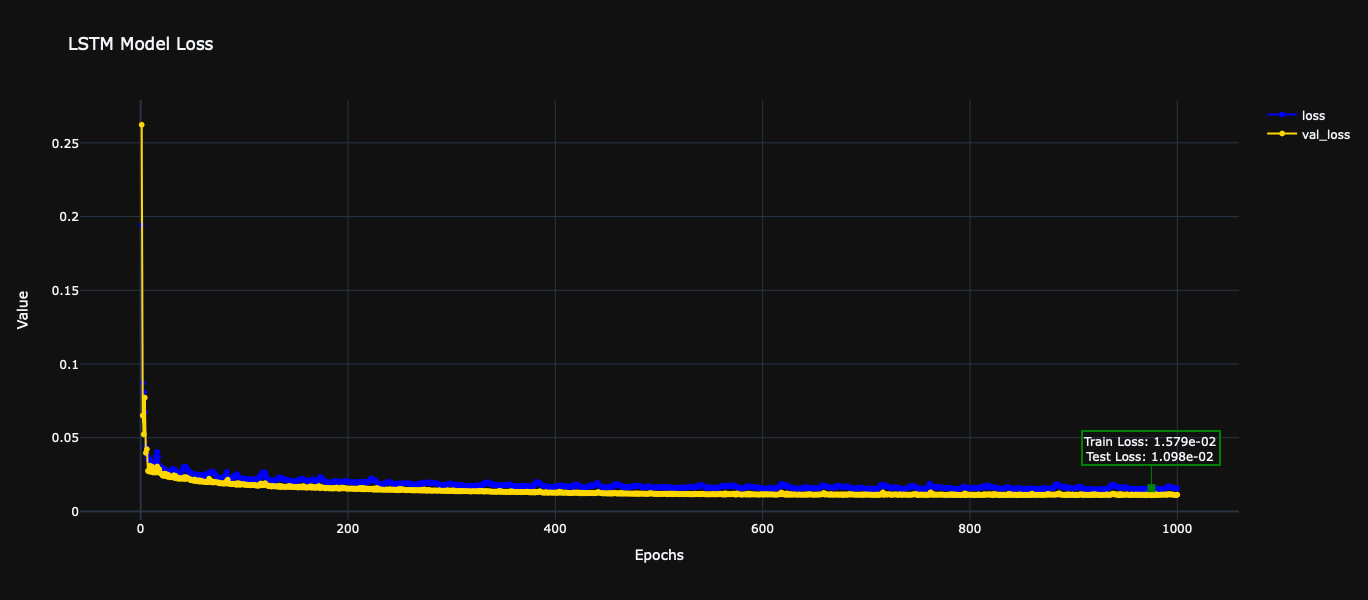

In [47]:
# Plotting LSTM model loss
plot_training_history(history.history, plot_title='LSTM Model Loss')

In [48]:
# Loading best wieghts during training
model = models.load_model(f'LSTM_Tesla_model.h5')

# Predicting
predictions = model.predict(X_test, verbose=False)
predictions = rnn_formater.scaler.inverse_transform(predictions)

# Showing predictions and data
index_1 = y_test.shape[0]
df_y_test = df[columns].iloc[-index_1:]
df_predictions = pd.DataFrame(predictions, index=df_y_test.index, columns=[f'pred_{col}' for col in columns])
df_test_pred = pd.concat([df_y_test, df_predictions], axis=1)
                         
# Shwoing outputs
highlight_half(df_test_pred.tail(), axis=1)

### <p style="background-image: linear-gradient(to right, rgba(49, 49, 90, 0.9), rgba(49, 49, 49, 0.0)), url(https://www.thedataschool.com.au/wp-content/uploads/2020/09/stock-tracking-screen-wo.jpg); background-size: cover; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; font-size: 105%; color: #E82127; text-align: left; border-radius: 5px; padding: 10px; box-shadow: 2px 2px 5px #333; margin-bottom: -10px;"> 5.2.1 $\vert$ LSTM Residual Analysis </p>

In [50]:
# Error dataframe
df_error = pd.DataFrame(df_predictions.values - df_y_test.values, index=df.index[-index_1:], columns=[f'error_{col}' for col in columns])
print('RMSE Per Column')
print((df_error**2).mean()**(1/2))

RMSE Per Column
error_open      4.205699e+00
error_high      5.468609e+00
error_low       5.348143e+00
error_close     7.462507e+00
error_volume    1.715615e+07
dtype: float64


In [51]:
def plotly_residual_analysis(df, title_add=''):
    """
    Perform residual analysis for multiple features in a DataFrame.
    The DataFrame should contain actual and predicted columns for each feature.
    
    Args:
        df (pd.DataFrame): DataFrame containing actual and predicted columns.
        title_add (str, optional): Additional title for the subplots.
    """
    # Number of columns
    columns = [col for col in df.columns if not col.startswith('pred_')]
    num_features = len(columns)

    # Color per column
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'yellow']

    # Subplots per columns
    fig = make_subplots(rows=num_features, cols=4, vertical_spacing=0.035, horizontal_spacing=0.035,
                        subplot_titles=("Histogram", "QQ-Normal Plot", "Residuals vs. Predicted Values", "Residuals vs Index"))

    for i, col in enumerate(columns):
        actual = df[col]
        predicted = df[f'pred_{col}']
        residuals = actual - predicted
        mean_residuals = np.mean(residuals)
        sd_residuals = np.std(residuals)
        rmse = np.sqrt(np.mean(residuals**2))
        index = df.index

        # Assign color for each feature
        color = colors[i % len(colors)]

        # Histogram of residuals
        fig.add_trace(go.Histogram(x=residuals, nbinsx=30, name=f'{col.title()} Residuals', marker_color=color), row=i+1, col=1)
        # Add lines for mean and standard deviation
        fig.add_vline(x=mean_residuals, line=dict(color='black', width=2), row=i+1, col=1)
        fig.add_vline(x=mean_residuals + sd_residuals, line=dict(color='grey', width=2, dash='dash'), row=i+1, col=1)
        fig.add_vline(x=mean_residuals - sd_residuals, line=dict(color='grey', width=2, dash='dash'), row=i+1, col=1)
        fig.add_annotation(x=mean_residuals, y=5, text=f"Mean: {mean_residuals:.2f}", showarrow=True, row=i+1, col=1)
        fig.add_annotation(x=sd_residuals + mean_residuals, y=5, text=f"SD: {sd_residuals:.2f}", showarrow=False, row=i+1, col=1)
        
        # QQ-Normal of residuals
        qq = stats.probplot(residuals, dist="norm", plot=None)
        fig.add_trace(go.Scatter(x=qq[0][0], y=qq[1][1] + qq[1][0]*qq[0][0], mode='lines',  showlegend=False), row=i+1, col=2)
        fig.add_trace(go.Scatter(x=qq[0][0], y=qq[0][1], mode='markers', marker_color=color, name=f'{col.title()} QQ'), row=i+1, col=2)

        # Residuals vs. predicted values
        fig.add_trace(go.Scatter(x=predicted, y=residuals, mode='markers', marker_color=color, name=f'{col.title()} Resid Pred'), row=i+1, col=3)
        fig.add_hline(y=0, line=dict(color='red'), row=i+1, col=3)
        fig.add_hline(y=2 * rmse, line=dict(color='red', dash='dash'), row=i+1, col=3)
        fig.add_hline(y=-2 * rmse, line=dict(color='red', dash='dash'), row=i+1, col=3)

        # Residuals vs. index
        fig.add_trace(go.Scatter(x=index, y=residuals, mode='markers', marker_color=color, name=f'{col.title()} Resid Index'), row=i+1, col=4)
        fig.add_hline(y=0, line=dict(color='red'), row=i+1, col=4)
        fig.add_hline(y=2 * rmse, line=dict(color='red', dash='dash'), row=i+1, col=4)
        fig.add_hline(y=-2 * rmse, line=dict(color='red', dash='dash'), row=i+1, col=4)

    # Update layout
    fig.update_layout(height=250*num_features, width=1400, title_text="Residual Analysis " + title_add)
    fig.show()

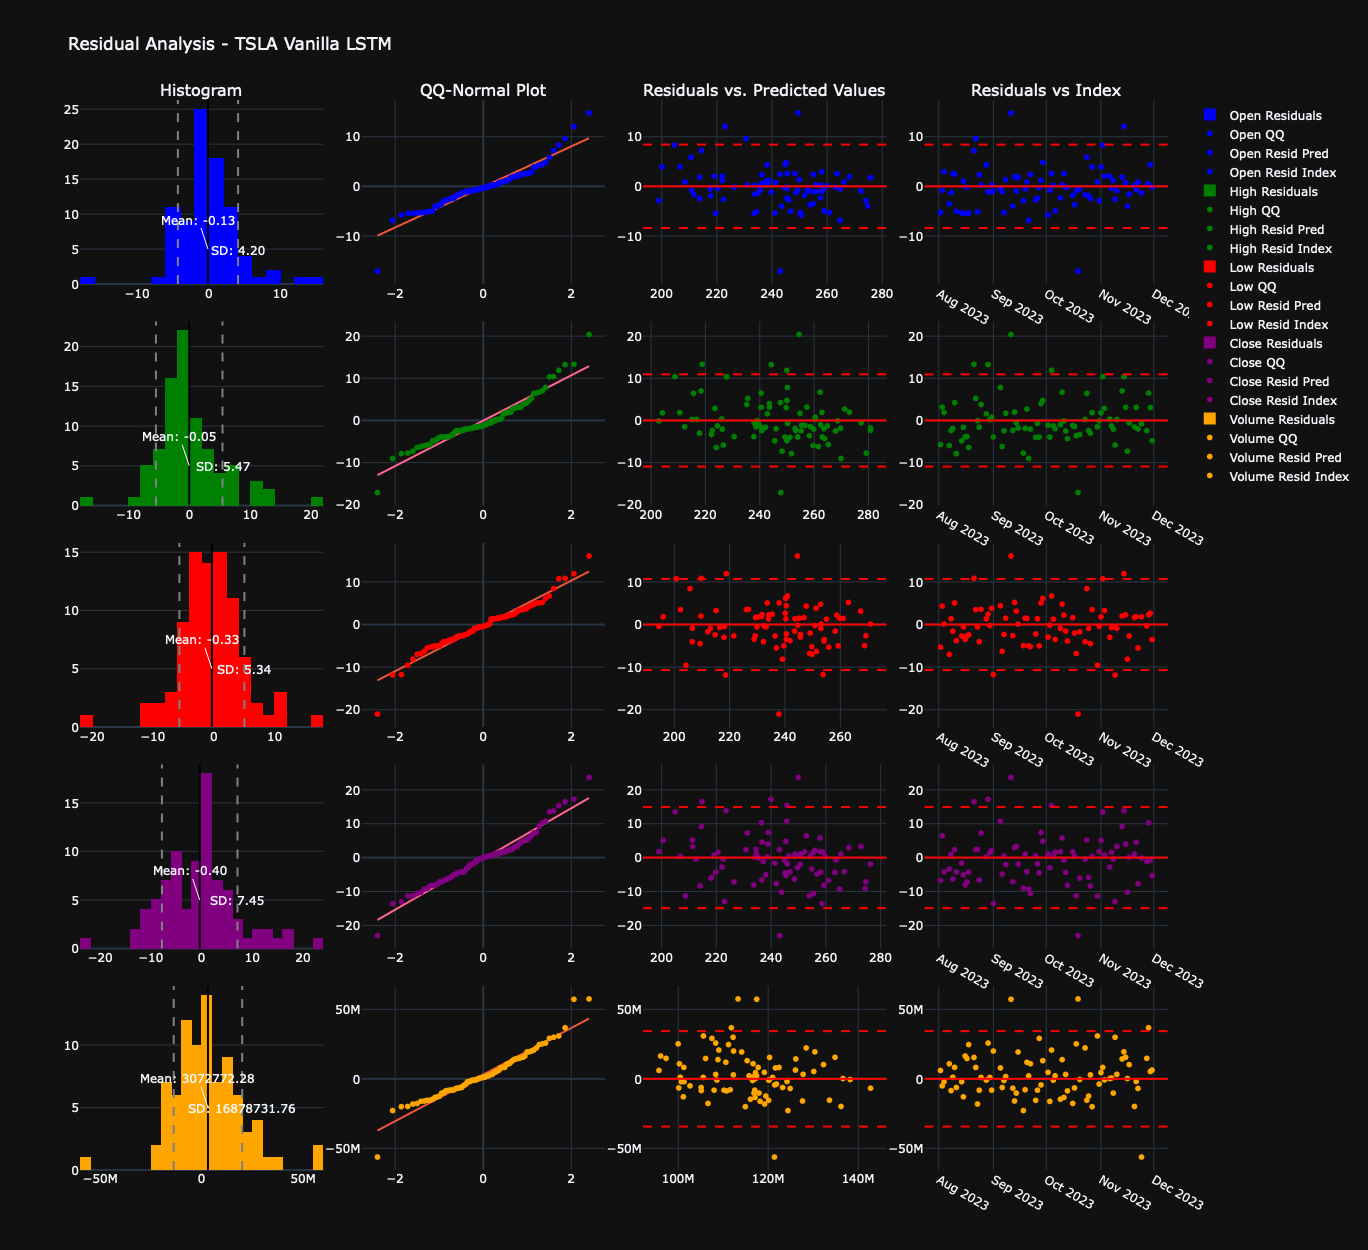

In [52]:
# Residual Analysis Plot
plotly_residual_analysis(df_test_pred, 
                         title_add=f'- {SYMBOL} Vanilla LSTM')

<a name='pred'>
    
## <p style="background-image: linear-gradient(to right, rgba(49, 49, 90, 0.9), rgba(49, 49, 49, 0.0)), url(https://www.thedataschool.com.au/wp-content/uploads/2020/09/stock-tracking-screen-wo.jpg); background-size: cover; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; font-size: 115%; color: #E82127; text-align: left; border-radius: 5px; padding: 10px; box-shadow: 2px 2px 5px #333; margin-bottom: -10px;"> 5.3 $\vert$ LSTM Predictions </p>

In [54]:
def plot_predictions(y_values_df, predictions_df, title_add=''):
    """
    Plots actual values and predictions for each feature in separate subplots.
    
    Args:
        y_values_df (pd.DataFrame): DataFrame containing actual values.
        predictions_df (pd.DataFrame): DataFrame containing predicted values.
        title_add (str, optional): Additional title for the subplots.
    """
    # Number/color per features 
    columns = [col for col in y_values_df.columns]
    num_features = len(columns)
    actual_colors = ['cyan', 'lime', 'yellow', 'violet', 'gold', 'pink']

    # Creating subplots
    fig = make_subplots(rows=num_features, cols=1, vertical_spacing=0.03, subplot_titles=[col.title() for col in columns])

    for i, col in enumerate(columns):
        # Actual values trace
        fig.add_trace(go.Scatter(x=y_values_df.index, y=y_values_df[col], mode='lines', name=col.title(),
                                 line=dict(color=actual_colors[i % len(actual_colors)])), row=i+1, col=1)
        
        # Predicted values trace
        pred_col = f'pred_{col}'
        if pred_col in predictions_df.columns:
            fig.add_trace(go.Scatter(x=predictions_df.index, y=predictions_df[pred_col], 
                                     mode='lines', name=f'Predicted {col.title()}', line=dict(color='red')), row=i+1, col=1)
            
            # Calculate RMSE and add as an annotation
            rmse = np.sqrt(np.mean((y_values_df[col] - predictions_df[pred_col]) ** 2))
            fig.add_annotation(xref='x domain', yref='y domain', x=1, y=0.05, showarrow=False,
                               text=f'RMSE: {rmse:.2f}', row=i+1, col=1, font=dict(color='red'))
    fig.update_layout(height=350*num_features, width=1300, title_text="Data & Predictions " + title_add)
    fig.show()


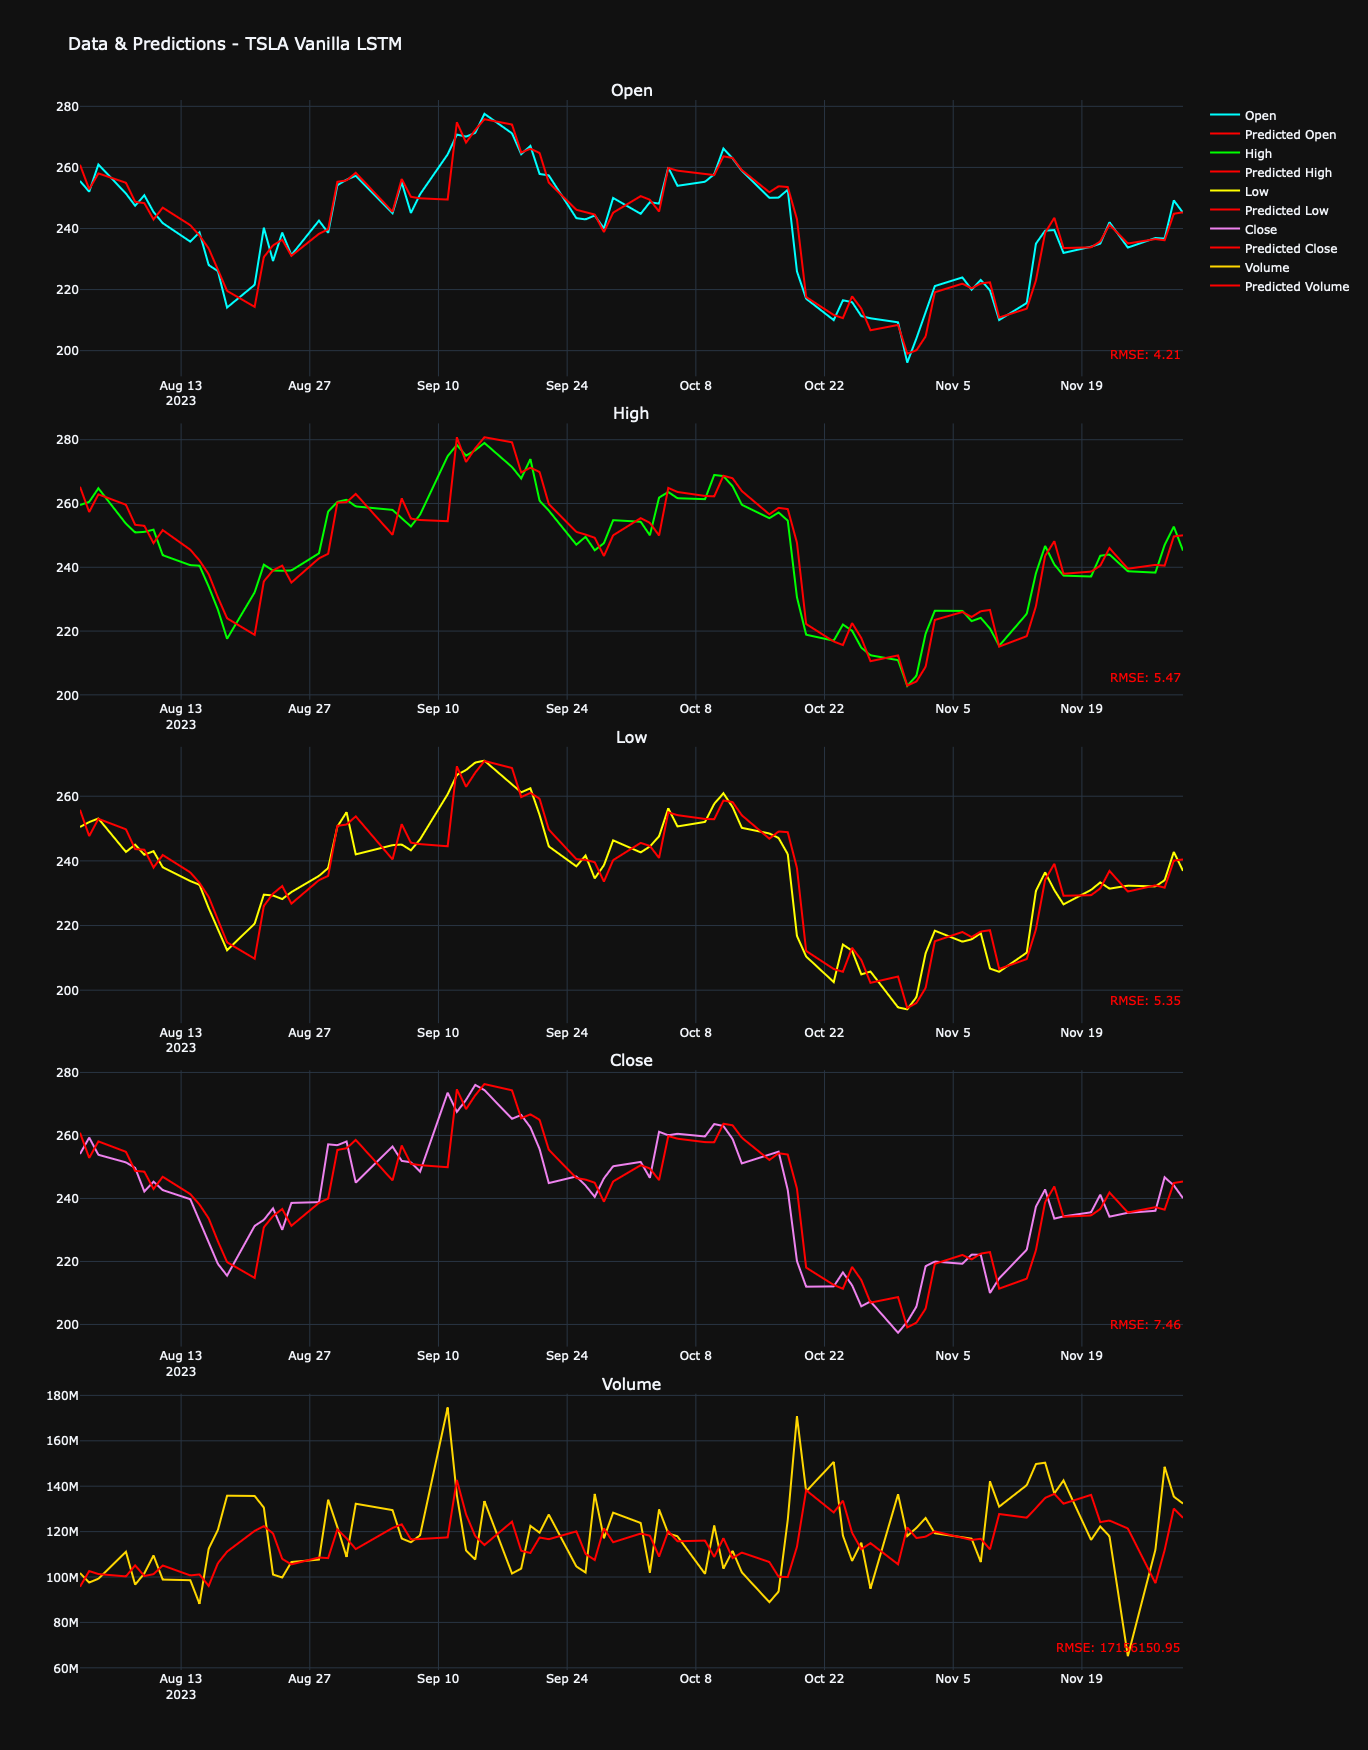

In [55]:
# Plotting prediction and data
plot_predictions(df_y_test, df_predictions, title_add=f'- {SYMBOL} Vanilla LSTM')

### <p style="background-image: linear-gradient(to right, rgba(49, 49, 90, 0.9), rgba(49, 49, 49, 0.0)), url(https://www.thedataschool.com.au/wp-content/uploads/2020/09/stock-tracking-screen-wo.jpg); background-size: cover; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; font-size: 100%; color: #E82127; text-align: left; border-radius: 5px; padding: 10px; box-shadow: 2px 2px 5px #333;">   5.3.1 $\vert$ Forecasting with LSTM Model </p>

In [57]:
# Getting last steps for LSTM forecast
last_steps = df[columns].iloc[-mapping_steps:, :]

# Number of steps to forecast
n_forecast_steps = 10 # ~ 2 weeks in business days

# Forming date index
date_index = pd.date_range(start=end_date, periods=n_forecast_steps, freq=BDay())

# Forecasting n-steps
forecast_array = rnn_formater.forecast_n_steps(model, last_steps, n_forecast_steps)
forecast = pd.DataFrame(forecast_array, index=date_index, columns=[f'forecast_{col}' for col in columns])
show(forecast)

In [58]:
# Plotting function
def plot_stock_data(df, previous_data=None, test_data=None, title_add=''):
    colors = ['blue', 'green', 'purple', 'orange', 'cyan']

    fig = make_subplots(rows=df.shape[1], cols=1, shared_xaxes=True, vertical_spacing=0.02,
                        subplot_titles=df.columns)

    for i, col in enumerate(df.columns):
        fig.add_trace(
            go.Scatter(x=df.index, y=df[col], mode='lines', name=col, line=dict(dash='dashdot', color='red'),
                      ), row=i+1, col=1)

        if previous_data is not None:
            column = list(previous_data.columns)[i]
            fig.add_trace(go.Scatter(x=previous_data.index, y=previous_data[column], mode='lines', name=column,
                                     line=dict(color=colors[i % len(colors)])), row=i+1, col=1)

        if test_data is not None:
            column = list(test_data.columns)[i]
            fig.add_trace(
                go.Scatter(x=test_data.index, y=test_data[column], mode='lines', name=f'Unseen {col.title()}',
                           line=dict(color='floralwhite')), row=i+1, col=1)
            

    fig.update_layout(height=1200, width=1000, title_text=f"Stock Data Over Time {title_add}")
    fig.show()

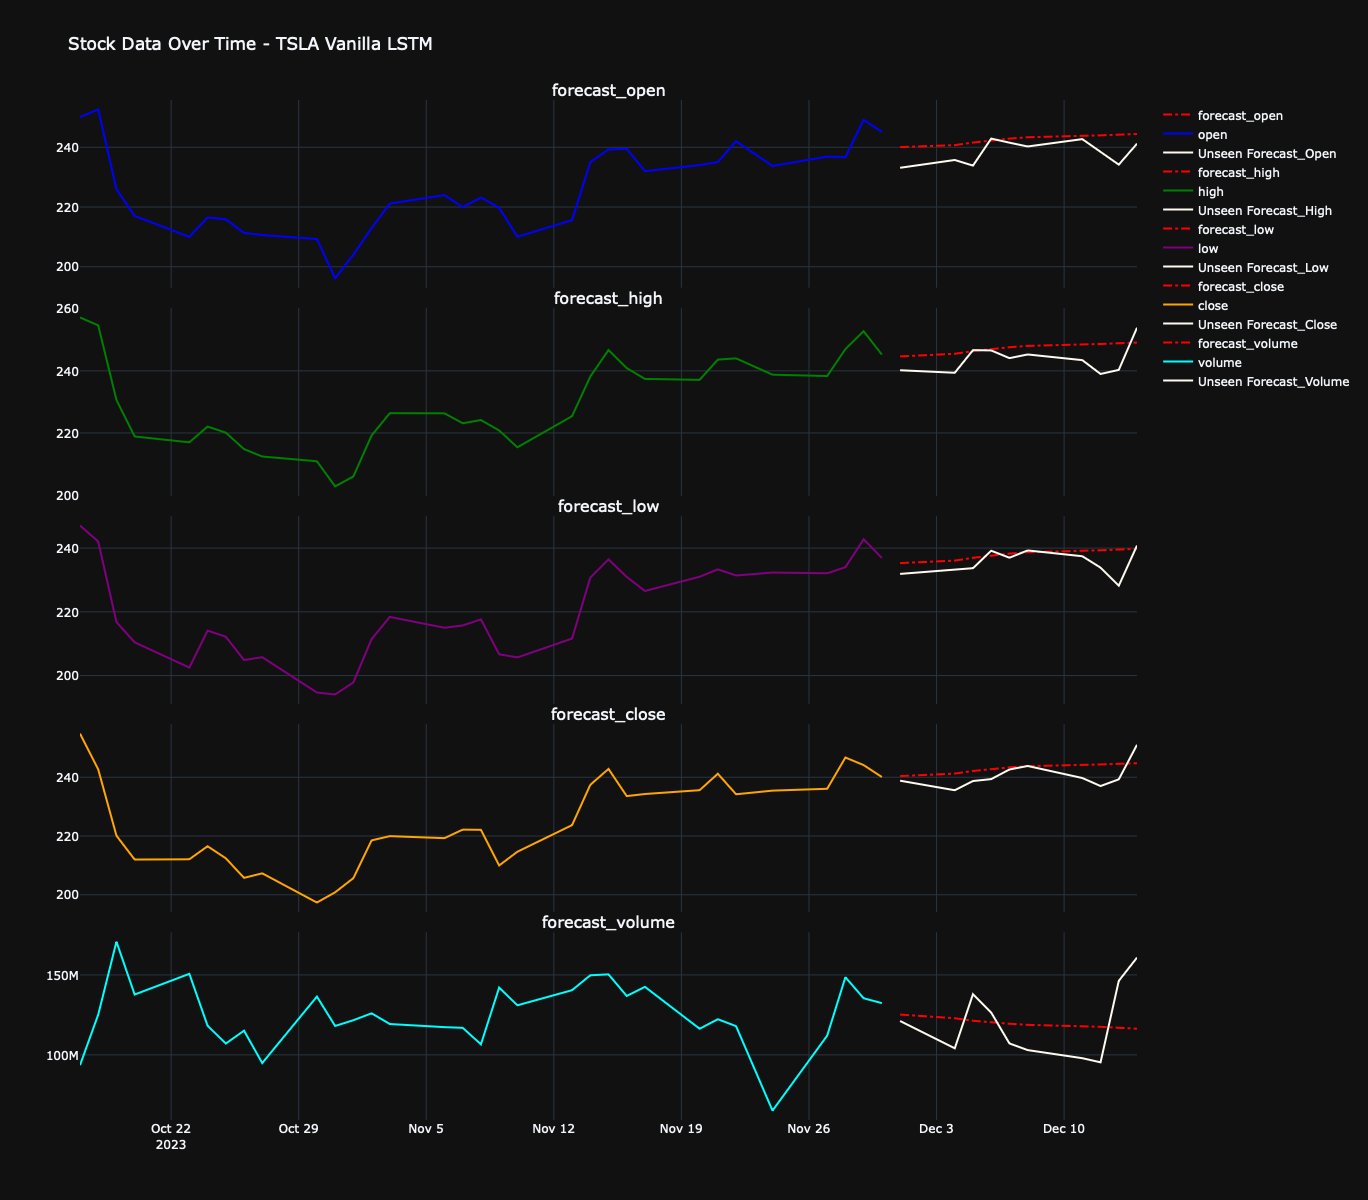

In [59]:
# Actual stock values to test forecast
df_test = ticker.history(start=end_date, end='2023-12-15').iloc[-n_forecast_steps:, :]
df_test.columns = df_test.columns.str.lower()

# Plotting forecast
plot_stock_data(forecast, last_steps, df_test, title_add=f'- {SYMBOL} Vanilla LSTM')

In [60]:
# Error per column on New Data
error_array = forecast.values - df_test[columns].values
errors = pd.DataFrame(error_array, index=df_test.index, columns=[f'error_{col}' for col in columns])
show(errors)

In [61]:
# RMSE per column on New Data
root_mean_squared_error = np.sqrt((errors**2).mean())
root_mean_squared_error = pd.DataFrame(root_mean_squared_error, columns=['RMSE New TLSA Data'])
show(root_mean_squared_error.T)

- This is very simimilar to the error on the test data used in the validation of the LSTM above!

<a name='mlstm'>

# <p style="background-image: linear-gradient(to right, rgba(49, 49, 90, 0.9), rgba(49, 49, 49, 0.0)), url(https://www.thedataschool.com.au/wp-content/uploads/2020/09/stock-tracking-screen-wo.jpg); background-size: cover; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; font-size: 150%; color: #E82127; text-align: left; border-radius: 5px; padding: 10px; box-shadow: 2px 2px 5px #333; margin-bottom: -10px;"> 6 $\vert$ Multi-Step Stacked LSTM Model <br> <small style="font-size: 55%;">  6.1 $\vert$ Multi-Step Mathematical Background <br> </p>

In a multi-step time series forecasting scenario using LSTMs, the mapping of input sequences to output sequences is a crucial aspect. This process involves using sequences of historical data to predict a sequence of future data points.

#### General Representation of Multi-Step Mapping
1. **Input Sequence (X):** Given a time series, the input to the LSTM model is a sequence of data points collected over a fixed number of past time steps. For a sequence with `n` time steps, the input sequence $ X_i $ is represented as:
   $$ X_i = [x_{i}, x_{i+1}, ..., x_{i+n-1}] $$
   where $ x_j $ denotes the data point at time $ j $.

2. **Output Sequence (y):** The LSTM model is tasked with predicting future values for a specific number of steps ahead. For predicting `m` steps into the future, the output sequence $ y_i $ from the model is:
   $$ y_i = [y_{i+n}, y_{i+n+1}, ..., y_{i+n+m-1}] $$
   where $ y_k $ is the predicted value at time $ k $.

#### Mathematical Formulation of Sequence Mapping
Let's denote $ t $ as the current time step, the LSTM model processes each input sequence to produce the corresponding output sequence. The mapping can be abstractly expressed as:
$$\textbf{LSTM}(X_i)\rightarrow y_i $$

This means the LSTM takes the input sequence $ X_i $ and produces the output sequence $ y_i $, which is essentially the forecast for the next `m` time steps. This approach allows the LSTM to analyze patterns over a period and make predictions about stock price trends for an upcoming time-frame. 

**Key Notes:** The core challenge in multi-step forecasting is to effectively learn and leverage the temporal relationships across a longer historical period (input sequence) to predict a future sequence. This is more complex than single-step forecasting, where the model predicts only the immediate next value. The advantage, however, is the ability to provide a more comprehensive and longer-term forecast.

<a name='background'>

## <p style="background-image: linear-gradient(to right, rgba(49, 49, 90, 0.9), rgba(49, 49, 49, 0.0)), url(https://www.thedataschool.com.au/wp-content/uploads/2020/09/stock-tracking-screen-wo.jpg); background-size: cover; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; font-size: 100%; color: #E82127; text-align: left; border-radius: 5px; padding: 10px; box-shadow: 2px 2px 5px #333; margin-bottom: -10px;">   6.2 $\vert$ Understanding Stacked LSTM </p>

In time series forecasting, such as predicting stock prices, we often use Long Short-Term Memory (LSTM) networks due to their ability to capture temporal dependencies. Two common architectures of LSTM models are single-layer and stacked (multi-layer) LSTMs. Each has unique characteristics suited for different complexities in time series data.

#### Single-Layer LSTM
A single-layer LSTM consists of one LSTM layer. It is relatively simpler and can efficiently model time series data where relationships between time steps are not overly complex. This architecture is particularly effective for shorter sequences or less volatile data.

- **Simplicity:** Easier to train and less prone to overfitting on smaller datasets.
- **Speed:** Generally faster to train due to fewer parameters.
- **Use Case:** Ideal for more straightforward time series problems where the relationship between past and future data points is more linear or less volatile.
- **Mathematical Process:** Each time step's input is processed through a series of gates (forget, input, and output) within this single layer, which influences the hidden state and cell state.
- **Equations:** The LSTM unit updates are based on the current input and the previous hidden state. The mathematical operations are confined within a single series of transformations:
  $$ h_t, C_t = LSTM(x_t, h_{t-1}, C_{t-1}) $$
  where $ h_t $ and $ C_t $ are the hidden and cell states at time $ t $, and $ x_t $ is the input at time $ t $.


#### Stacked LSTM
Stacked LSTM, in contrast, involves multiple LSTM layers stacked on top of each other. Each layer feeds into the next, allowing the model to learn from a more nuanced representation of the data.

- **Complexity:** Better at capturing complex patterns and relationships in the data. Each layer can learn different aspects of the data, offering a more detailed analysis.
- **Flexibility:** Can model more complex and longer sequences, making it suitable for volatile or non-linear time series data like stock prices.
- **Depth:** The additional layers provide a deeper understanding, enabling the model to capture subtler temporal dynamics.
- **Mathematical Process:** The first LSTM layer processes the input sequence and passes its hidden state outputs to the second layer. This process repeats across all layers, with each layer learning different aspects of the data.
- **Equations:** The transformations occur sequentially across layers. For a two-layer stacked LSTM, the process can be described as:
  $$ h_t^{(1)}, C_t^{(1)} = LSTM^{(1)}(x_t, h_{t-1}^{(1)}, C_{t-1}^{(1)}) $$
  $$ h_t^{(2)}, C_t^{(2)} = LSTM^{(2)}(h_t^{(1)}, h_{t-1}^{(2)}, C_{t-1}^{(2)}) $$
  where superscripts denote the layer numbers.

  
#### Key Notes
- **Performance:** Stacked LSTMs tend to perform better on complex problems, but they require more data and computational resources. Single-layer LSTMs are more efficient on simpler tasks.
- **Application:** The choice between single-layer and stacked LSTMs depends on the specific requirements of the time series problem. For instance, stock market predictions, known for their volatility and non-linearity, often benefit from the depth provided by stacked LSTMs.
- **Depth of Learning:** In stacked LSTMs, the data goes through multiple levels of processing, allowing the model to capture more complex and abstract features of the time series.
- **Capacity:** Stacked LSTMs have a higher capacity to model complex problems due to the additional layers but require more data to train effectively without overfitting.
- **Computational Complexity:** Stacked LSTMs are computationally more intensive due to the increased number of parameters and layers[1, 2].

<a name='mutlidataprep'>

## <p style="background-image: linear-gradient(to right, rgba(49, 49, 90, 0.9), rgba(49, 49, 49, 0.0)), url(https://www.thedataschool.com.au/wp-content/uploads/2020/09/stock-tracking-screen-wo.jpg); background-size: cover; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; font-size: 100%; color: #E82127; text-align: left; border-radius: 5px; padding: 10px; box-shadow: 2px 2px 5px #333; margin-bottom: -10px;">   6.3 $\vert$ Multi-Step LSTM Data Prep</p>

In [65]:
class RNNFormaterMultiStep:
    def __init__(self, data: pd.DataFrame, n_steps_in, n_steps_out):
        """
        Initialize the RNNFormater with a DataFrame, number of input steps, and number of output steps.
        
        Args:
            data (pd.DataFrame): Input DataFrame containing time series data.
            n_steps_in (int): Number of time steps for each input sequence.
            n_steps_out (int): Number of time steps for each output sequence.
        """
        self.df = data.copy()
        self.n_steps_in = n_steps_in
        self.n_steps_out = n_steps_out
        self.n_columns = self.df.shape[1]
        
        self.scaler = MinMaxScaler()
        self.normalized_data = self.scaler.fit_transform(self.df.values)

    def data_mapping(self):
        """
        Maps a 2D array into a 3D array for RNN input, with each sequence having n_steps_in time steps
        and each target having n_steps_out time steps.
        
        Returns:
            X (np.array): A 3D array of input sequences.
            y (np.array): A 3D array of target sequences.
        """
        num_samples = len(self.normalized_data) - self.n_steps_in - self.n_steps_out + 1

        X = np.empty((num_samples, self.n_steps_in, self.n_columns))
        y = np.empty((num_samples, self.n_steps_out, self.n_columns))

        for i in range(num_samples):
            X[i, :, :] = self.normalized_data[i:i + self.n_steps_in, :]
            y[i, :, :] = self.normalized_data[i + self.n_steps_in:i + self.n_steps_in + self.n_steps_out, :]

        return X, y

    def rnn_train_test_split(self, X, y, test_percent=0.1):
        """
        Splits the 3D mapped data into training and testing sets for an RNN.
        
        Args:
            X (np.array): The input data sequences.
            y (np.array): The target data sequences.
            test_percent (float): The fraction of data to be used for testing.
        
        Returns:
            X_train, X_test, y_train, y_test (tuple): Split data into training and testing sets.
        """
        test_size = int(len(X) * test_percent)
        X_train, y_train = X[:-test_size], y[:-test_size]
        X_test, y_test = X[-test_size:], y[-test_size:]

        return X_train, X_test, y_train, y_test

    def multi_step_forecast(self, model, data: np.array):
        """
        Forecast multiple steps ahead using the LSTM model.
        
        Args:
            model (tf.keras.Model): Trained LSTM model for prediction.
            data (pd.DataFrame): Input DataFrame containing the latest time series data.
        
        Returns:
            pd.DataFrame: Forecasted values for n_steps_out steps.
        """    
        # Normalizing latest data
        last_steps_normalized = self.scaler.transform(data)
        last_steps_normalized = last_steps_normalized.reshape(1, self.n_steps_in, self.n_columns)
        
        # Predicting using model
        forecast = model.predict(last_steps_normalized)
        forecast = forecast.reshape(self.n_steps_out, self.n_columns)

        # Inverse transforming to original scale
        forecast = self.scaler.inverse_transform(forecast)
        forecast = pd.DataFrame(forecast, columns=[f'forecast_{col}' for col in self.df.columns])
        
        return forecast
        

<a name='buildmlstm'>

## <p style="background-image: linear-gradient(to right, rgba(49, 49, 90, 0.9), rgba(49, 49, 49, 0.0)), url(https://www.thedataschool.com.au/wp-content/uploads/2020/09/stock-tracking-screen-wo.jpg); background-size: cover; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; font-size: 100%; color: #E82127; text-align: left; border-radius: 5px; padding: 10px; box-shadow: 2px 2px 5px #333; margin-bottom: -10px;">   6.4 $\vert$ Buidling Stacked Multi-Step LSTM </p>

Here, we use again use the `MinMaxScaler` from the `sklearn.preprocessing`, this is nicely done in the class `RNNFormaterMultiStep`

**In our example we have our Tesla stock price prediction model:**
- **Input (X):** We map `252` time steps of past stock prices, representing about `1 year` of stock data in business days.
- **Output (y):** The model forecasts the next `21` time steps, equivalent to `1 month` ahead in business days.


--- 

**What It Is**: `kernel_initializer` in neural networks, such as those in Keras/TensorFlow, is a parameter that sets the method to initialize the weights in a layer.

**Mathematical Basis**: 
- Orthogonal Initialization: This method sets weights as orthogonal matrices, preserving the variance from input to output of the layer. Mathematically, for a weight matrix $ W $, it ensures $ W^T W = I $ or $ W W^T = I $ with $ I $ being the identity matrix.

**Why It Matters**: 
- Proper weight initialization is crucial for efficient training. It can impact the speed of convergence and the final performance of the network.
- Orthogonal initialization is beneficial in deep networks as it avoids vanishing and exploding gradients.


### <p style="background-image: linear-gradient(to right, rgba(49, 49, 90, 0.9), rgba(49, 49, 49, 0.0)), url(https://www.thedataschool.com.au/wp-content/uploads/2020/09/stock-tracking-screen-wo.jpg); background-size: cover; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; font-size: 100%; color: #E82127; text-align: left; border-radius: 5px; padding: 10px; box-shadow: 2px 2px 5px #333; margin-bottom: -10px;">   6.4.1 $\vert$ Bidirectional LSTM </p>

A **bidirectional LSTM** is a type of RNN architecture designed to process and analyze sequential data. Unlike traditional LSTMs that read sequences in one direction, bidirectional LSTMs process data in both forward and backward directions simultaneously. This bidirectional processing allows the model to capture dependencies from both past and future contexts.

During the training phase, the bidirectional LSTM considers information from earlier time steps to later ones, and vice versa. This helps the model understand patterns that may exist across various points in the sequence. The bidirectional LSTM consists of two separate layers – one processing the sequence from the beginning to the end, and the other from the end to the beginning. The outputs from both directions are typically concatenated or combined to provide a more comprehensive representation of the input sequence.

This architecture is useful in tasks where understanding both past and future information is essential, such as time-series analysis and natural language processing. By incorporating bidirectional processing, the LSTM becomes more adept at capturing complex relationships within sequential data.

**Bidirectional Model Example**

```python
# Multi-Step LSTM
ms_model = models.Sequential([
    LSTM(units=40, return_sequences=True, input_shape=(n_steps_in, len(columns)), kernel_initializer='orthogonal'),
    Bidirectional(LSTM(units=20, return_sequences=False)),
    Dense(units=n_steps_out * len(columns))   
])
```

In [67]:
n_steps_in = 252  # ~ 1 year in business days mapping
n_steps_out = 21  # ~ 1 month forecast in business days

# Intializing created RNN class
ms_rnn_formatter = RNNFormaterMultiStep(df[columns], n_steps_in, n_steps_out)

# Normalizing and data mappings for input & output
X, y = ms_rnn_formatter.data_mapping()

# Train Test split
X_train, X_test, y_train, y_test = ms_rnn_formatter.rnn_train_test_split(X, y)

print(f'X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}') # (time mapes, tiime steps, columns)
print(f'\nX_test shape: {X_test.shape}\ny_test shape: {y_test.shape}')

X_train shape: (1322, 252, 5)
y_train shape: (1322, 21, 5)

X_test shape: (146, 252, 5)
y_test shape: (146, 21, 5)


### <p style="background-image: linear-gradient(to right, rgba(49, 49, 90, 0.9), rgba(49, 49, 49, 0.0)), url(https://www.thedataschool.com.au/wp-content/uploads/2020/09/stock-tracking-screen-wo.jpg); background-size: cover; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; font-size: 100%; color: #E82127; text-align: left; border-radius: 5px; padding: 10px; box-shadow: 2px 2px 5px #333; margin-bottom: -10px;">   6.4.2 $\vert$ Training Stacked Multi-Step LSTM </p>

In [69]:
# For consistant results
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

# Multi-Step LSTM
ms_model = models.Sequential([
    
    # Layer 1
    LSTM(units=40, return_sequences=True, input_shape=(n_steps_in, len(columns)), kernel_initializer='orthogonal'),

    # Layer 2
    LSTM(units=20, return_sequences=False),
    # Bidirectional(LSTM(units=20, return_sequences=False)),

    # Output layer
    Dense(units=n_steps_out * len(columns))   
])

ms_model.compile(optimizer='adam', loss='mse')
ms_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 252, 40)           7360      
                                                                 
 lstm_2 (LSTM)               (None, 20)                4880      
                                                                 
 dense_1 (Dense)             (None, 105)               2205      
                                                                 
Total params: 14445 (56.43 KB)
Trainable params: 14445 (56.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [70]:
# Callback to save model weights
model_checkpoint = ModelCheckpoint('Multi_LSTM_Tesla_model.h5', monitor='val_loss', save_best_only=True)

# Fitting the model
ms_history = ms_model.fit(X_train, y_train.reshape(-1, n_steps_out * len(columns)), 
                          batch_size=1024,
                          epochs=200, 
                          validation_data=(X_test, y_test.reshape(-1, n_steps_out * len(columns))), 
                          callbacks=[model_checkpoint],
                          shuffle=False, 
                          verbose=False)

/Users/gassanyacteen/anaconda3/envs/Deep_Learning/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



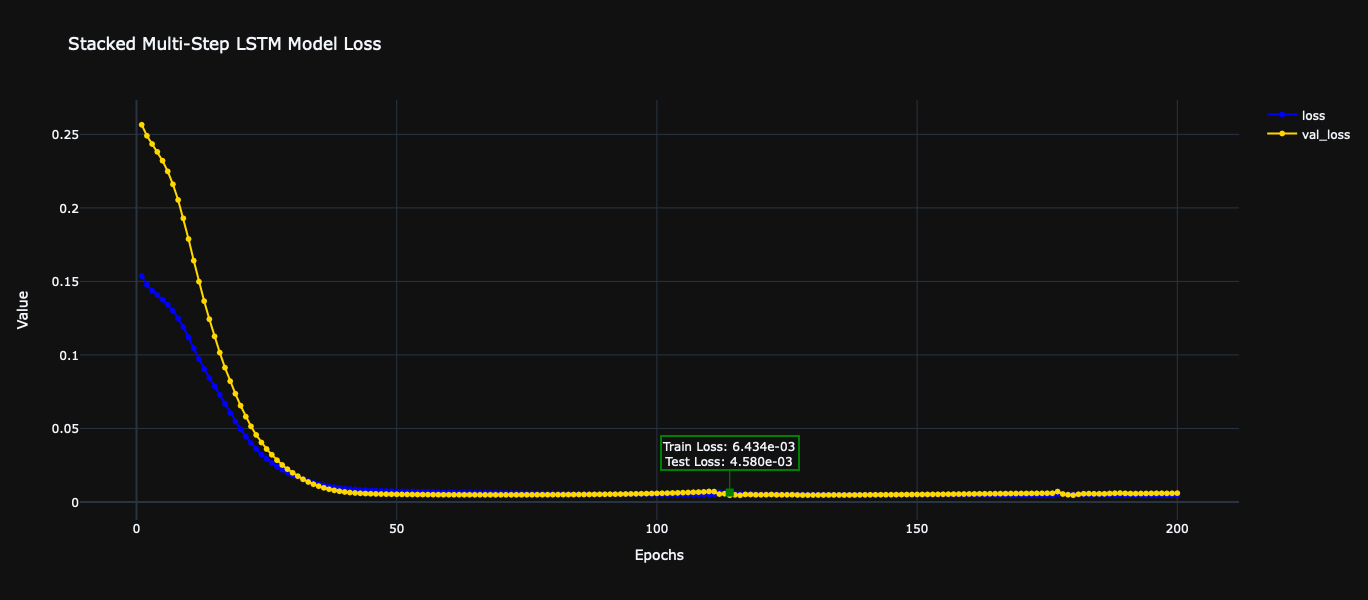

In [71]:
# Plotting stakced multi-step model loss
plot_training_history(ms_history.history,
                      plot_title='Stacked Multi-Step LSTM Model Loss')

<a name='forecast'>

## <p style="background-image: linear-gradient(to right, rgba(49, 49, 90, 0.9), rgba(49, 49, 49, 0.0)), url(https://www.thedataschool.com.au/wp-content/uploads/2020/09/stock-tracking-screen-wo.jpg); background-size: cover; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; font-size: 100%; color: #E82127; text-align: left; border-radius: 5px; padding: 10px; box-shadow: 2px 2px 5px #333; margin-bottom: -10px;">   6.5 $\vert$ Multi-Step Forecasting with Stacked LSTM Model </p>

In [73]:
# Getting stock data for forecasting
data_to_test = df[columns].iloc[-n_steps_in:]

# Showing data
print(f'Test Data Shape: {data_to_test.shape}')
show(data_to_test.tail())

Test Data Shape: (252, 5)


In [74]:
# Loading best wieghts during training
ms_model = models.load_model('Multi_LSTM_Tesla_model.h5')

# Forecasting using rnn
forecast = ms_rnn_formatter.multi_step_forecast(ms_model, data_to_test.values)

# Setting index as datetime corresponding to forecast period
forecast.index = pd.date_range(start=end_date, periods=n_steps_out, freq=BDay())
print(f'Forecast shape: {forecast.shape}')
show(forecast)

1/1 [==============================] - 0s 324ms/step
Forecast shape: (21, 5)


In [75]:
def plot_forecast(previous_data, forecast, test_data=None, title_add=''):
    """
    Plots actual values and predictions for each feature in separate subplots.
    
    Args:
        previous_data (pd.DataFrame): DataFrame containing actual values.
        forecast (pd.DataFrame): DataFrame containing predicted values.
        title_add (str, optional): Additional title for the subplots.
    """
    # Number/color per features 
    columns = [col for col in previous_data.columns]
    num_features = len(columns)
    actual_colors = ['cyan', 'gold', 'violet', 'lime', 'blue', 'pink', 'yellow']

    # Creating subplots
    fig = make_subplots(rows=num_features, cols=1, vertical_spacing=0.03, subplot_titles=[col.title() for col in columns])

    for i, col in enumerate(columns):
        # Actual values trace
        fig.add_trace(
            go.Scatter(x=previous_data.index, y=previous_data[col], mode='lines', name=col.title(),
                       line=dict(color=actual_colors[i % len(actual_colors)])), row=i+1, col=1)
        
        # Predicted values trace
        pred_col = f'forecast_{col}'
        if pred_col in forecast.columns:
            fig.add_trace(
                go.Scatter(x=forecast.index, y=forecast[pred_col], 
                           mode='lines', name=f'Forecast {col.title()}', line=dict(color='red')), row=i+1, col=1)

        if test_data is not None:
            fig.add_trace(
                go.Scatter(x=test_data.index, y=test_data[col], mode='lines', name=f'Unseen {col.title()}',
                           line=dict(color='floralwhite')), row=i+1, col=1)
            
            
    fig.update_layout(height=350*num_features, width=1300, title_text="Data and Forecast " + title_add)
    fig.show()


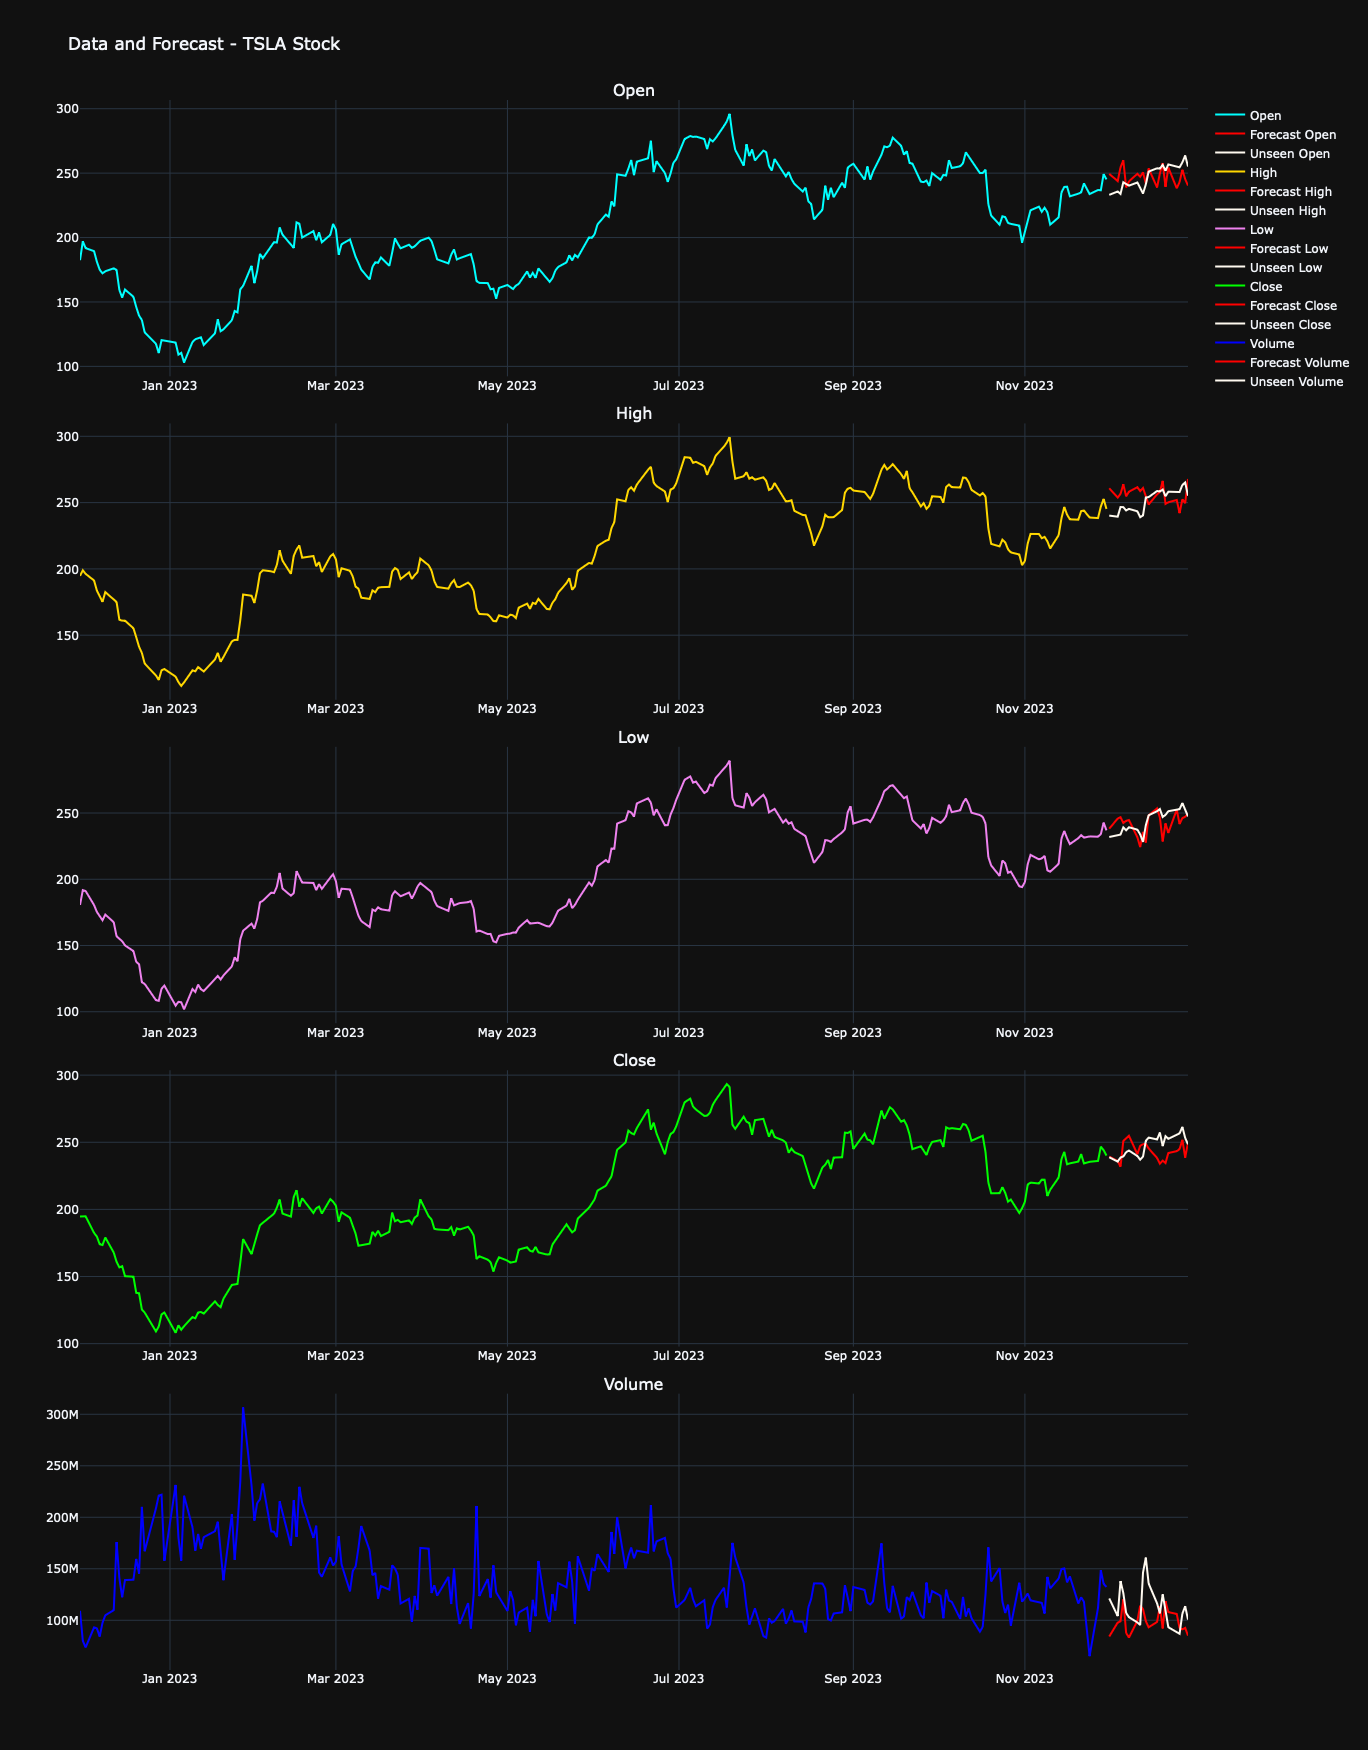

In [76]:
# Actual stock values to test forecast
df_test = ticker.history(start=end_date).iloc[-n_steps_out:, :]
df_test.columns = df_test.columns.str.lower()

# Plotting stacked mutli-step LSTM forecast
plot_forecast(data_to_test[columns], forecast, df_test, title_add='- TSLA Stock')

<a name='B'> 


## &#8711; <span style='color:red'>|</span> Table of Contents
1. [`Introduction`](#I)
2. [`Tesla Data`](#D)
3. [`Imports & Setup`](#is)
    * 3.1 [`Tesla Data`](#tsladata)
4. [`Data Visualization`](#DV)
    * 4.1 [`Candlestick Plots`](#DV)
    * 4.2 [`Stock Splits`](#splits)
    * 4.3 [`Percentage Change in Stock`](#pchange)
5. [`Single Step LSTM`](#lstm)
    * 5.1 [`Data Prep`](#lstm)
    * 5.2 [`Model Building`](#buildmodel)
    * 5.3 [`Predictions`](#pred)
6. [`Multi-Step Stacked LSTM`](#mlstm)
    * 6.1 [`Multi-Step Math Background`](#mlstm)
    * 6.2 [`Stacked LSTM Background`](#background)
    * 6.3 [`Multi-Step Data Prep`](#mutlidataprep)
    * 6.4 [`Buidling Stacked LSTM`](#buildmlstm)
    * 6.5 [`Forecasting Multi-Step Stacked LSTM`](#forecast)
7. [`Top`](#T)

- [1]. Mayank, M. (2020, October 17). A practical guide to RNN and LSTM in Keras. Medium. https://towardsdatascience.com/a-practical-guide-to-rnn-and-lstm-in-keras-980f176271bc 
- [2]. Understanding LSTM networks. Understanding LSTM Networks -- colah’s blog. (n.d.). https://colah.github.io/posts/2015-08-Understanding-LSTMs/ 

---